In [35]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [36]:
def add_gauss_noise(image, mean, sigma):
    image = np.array(image / 255, dtype=float)
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + noise
    out = np.clip(noisy_image, 0, 1.0)
    out = np.uint8(out * 255)
    return out

def add_salt_and_peper_noise(im, fraction=0.01):
    assert (0 < fraction <= 1.), "Fraction must be in (0, 1]"

    sp = np.zeros(im.shape)
    percent = round(fraction * 100 / 2.)

    cv.randu(sp, 0, 100)

    # quarter salt quarter pepper
    im_sp = im.copy()
    im_sp[sp < percent] = 0
    im_sp[sp > 100 - percent] = 255
    return im_sp

PSNR (peak signal-to-noise ratio, отношение пикового уровня сигнала к шуму) - наиболее часто используемая количественная метрика для измерения уровня искажений при работе с изображениями. 
PSNR наиболее часто используется для измерения уровня искажений при сжатии изображений. 

In [37]:
def getPSNR(I1, I2):
    s1 = cv.absdiff(I1, I2)  #|I1 - I2|
    s1 = np.float64(s1)  # cannot make a square on 8 bits
    s1 = s1 * s1  # |I1 - I2|^2
    sse = s1.sum()  # sum elements per channel
    if sse <= 1e-10:  # sum channels
        return 0  # for small values return zero
    else:
        mse = 1.0 * sse / np.prod(I1.shape)
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr

SSIM (structure similarity, структурное сходство) точнее учитывает особенности восприятия изображения и видео человеком.
SSIM метрика рассчитана на различные размеры окна. Разница между двумя окнами x и y имеющими одинаковый размер N×N:

In [38]:
def getSSIM(i1, i2):
    C1 = 6.5025  # only for 8-bit images
    C2 = 58.5225  # only for 8-bit images
    # INITS
    I1 = np.float64(i1)  # cannot calculate on one byte large values
    I2 = np.float64(i2)
    I2_2 = I2 * I2  # I2^2
    I1_2 = I1 * I1  # I1^2
    I1_I2 = I1 * I2  # I1 * I2
    # END INITS
    # PRELIMINARY COMPUTING
    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2  # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2  # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1)  # ssim_map =  t3./t1;
    ssim = np.mean(ssim_map)  # mssim = average of ssim map
    return ssim

PSNR =  18.905293323374412
SSIM =  0.9006962034347961


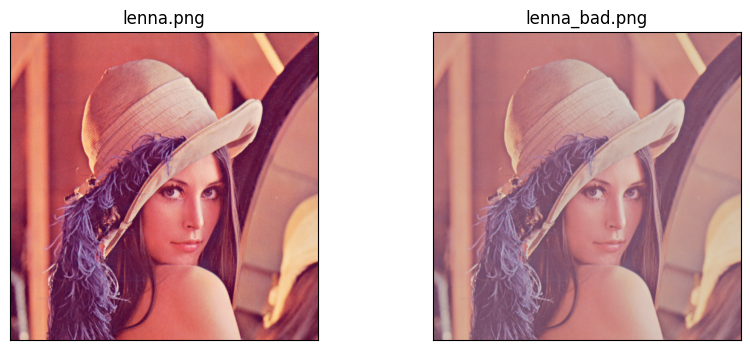

In [39]:
image1 = cv.imread('../images/lenna.png')
image2 = cv.imread('../images/lenna_bad.png')
gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
gray_image2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
rgb_image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)

# rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)

gs = plt.GridSpec(1, 2)
plt.figure(figsize=(10, 4))
plt.subplot(gs[0])
plt.imshow(rgb_image1)
plt.title('lenna.png')
plt.xticks([]), plt.yticks([])
plt.subplot(gs[1])
plt.imshow(rgb_image2)
plt.title('lenna_bad.png')
plt.xticks([]), plt.yticks([])

print('PSNR = ', getPSNR(image1.copy(), image2.copy()))
print('SSIM = ', getSSIM(image1.copy(), image2.copy()))

# Фильтрация изображений
### фильтрации изображений. Модели шумов

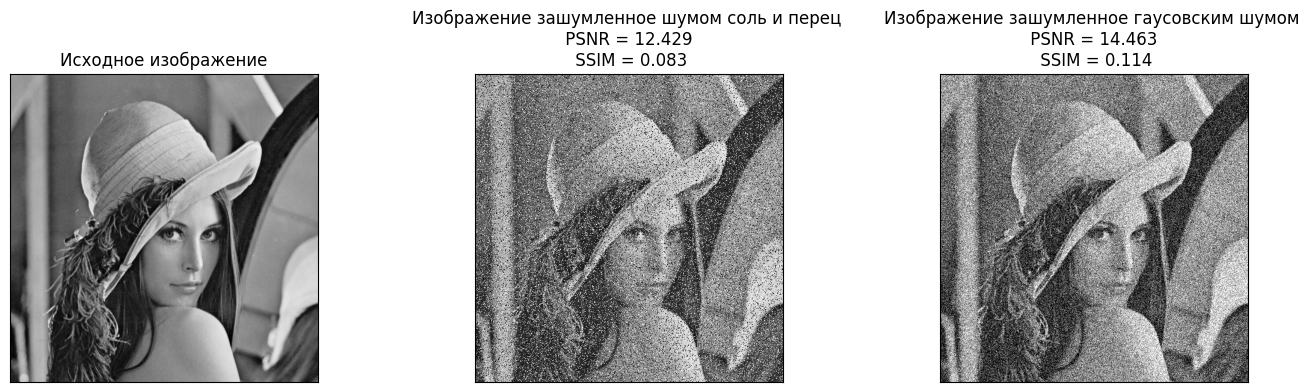

In [40]:
gs = plt.GridSpec(1, 3)
plt.figure(figsize=(17, 4))

plt.subplot(gs[0])
plt.title('Исходное изображение')
plt.xticks([]), plt.yticks([])
plt.imshow(gray_image1, cmap='gray')

plt.subplot(gs[1])
plt.xticks([]), plt.yticks([])
noisy_image = add_salt_and_peper_noise(gray_image1, 0.2)
psnr = getPSNR(gray_image1.copy(), noisy_image)
ssim = getSSIM(gray_image1.copy(), noisy_image)
plt.title(f'Изображение зашумленное шумом соль и перец \n PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')
plt.imshow(noisy_image, cmap='gray')

plt.subplot(gs[2])
plt.xticks([]), plt.yticks([])
noisy_image = add_gauss_noise(gray_image1, 0, 0.2)
psnr = getPSNR(gray_image1.copy(), noisy_image)
ssim = getSSIM(gray_image1.copy(), noisy_image)
plt.title(f'Изображение зашумленное гаусовским шумом \n PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')
plt.imshow(noisy_image, 'gray')
plt.show()

### Нелинейная фильтрация полутоновых изображений

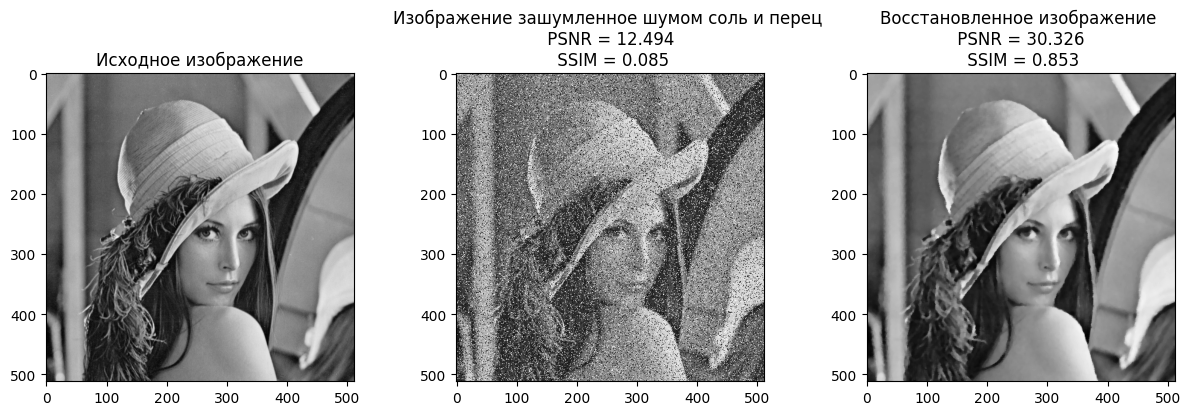

In [41]:
sap_image1 = add_salt_and_peper_noise(gray_image1, 0.2)
median_image1 = cv.medianBlur(sap_image1, 5)

gs = plt.GridSpec(1, 3)
plt.figure(figsize=(15, 4))
plt.subplot(gs[0])
plt.imshow(gray_image1, cmap='gray')
plt.title('Исходное изображение')
plt.subplot(gs[1])
plt.imshow(sap_image1, cmap='gray')
psnr = getPSNR(gray_image1.copy(), sap_image1)
ssim = getSSIM(gray_image1.copy(), sap_image1)
plt.title(f'Изображение зашумленное шумом соль и перец \n PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')
plt.subplot(gs[2])
plt.imshow(median_image1, cmap='gray')
psnr = getPSNR(gray_image1.copy(), median_image1)
ssim = getSSIM(gray_image1.copy(), median_image1)
plt.title(f'Восстановленное изображение \n PSNR = {psnr:.3f} \n SSIM = {ssim:.3f}')
plt.show()

# Линейная фильтрация изображений
### Линейная фильтрация изображений. Операция свертки. Линейная фильтрация в пространственной области

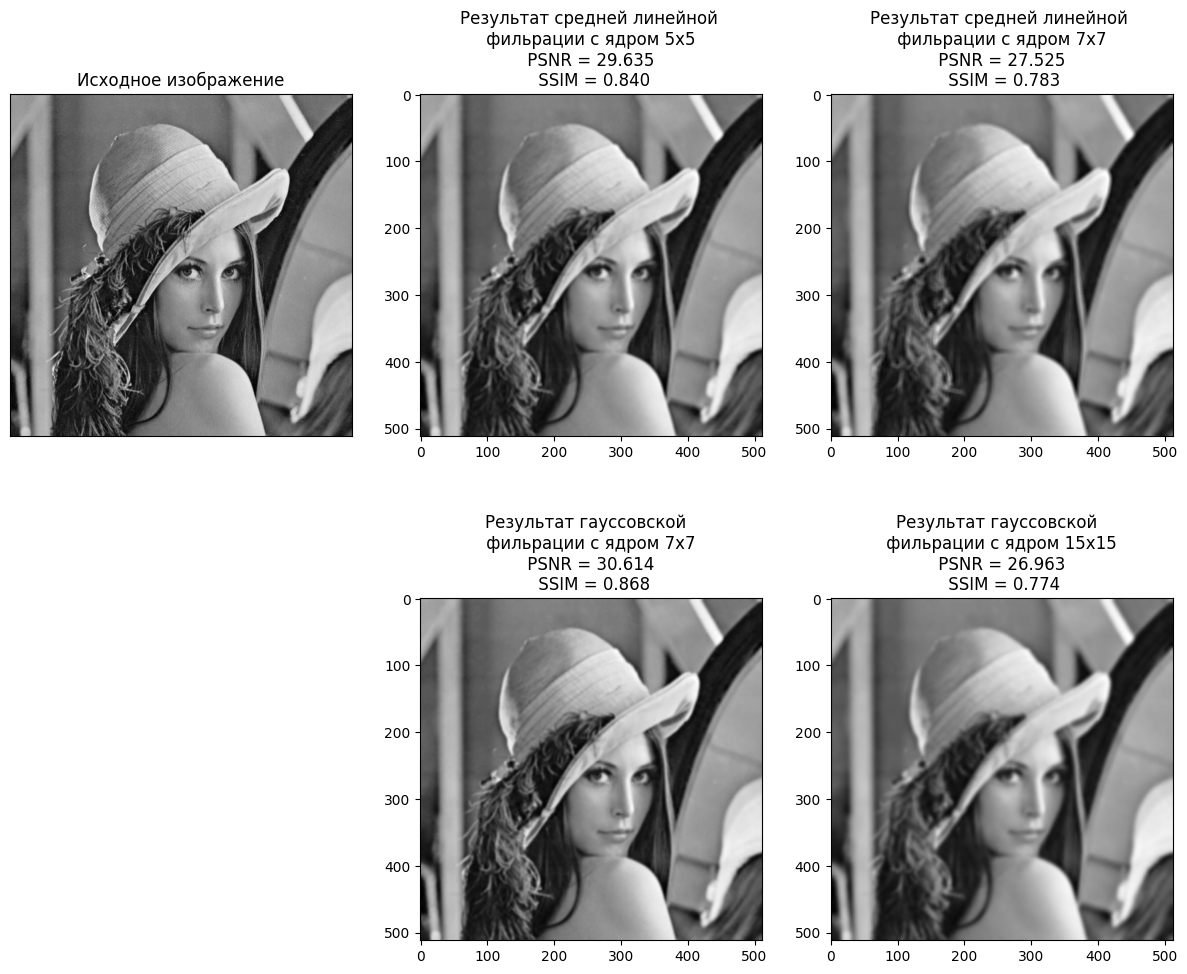

In [42]:
# Гауссовская фильтрация
kernel55 = np.ones((5, 5), np.float32) / 25
kernel77 = np.ones((7, 7), np.float32) / 49
filtered_image1 = cv.filter2D(gray_image1, -1, kernel55)
filtered_image2 = cv.filter2D(gray_image1, -1, kernel77)
filtered_image3 = cv.GaussianBlur(gray_image1, (7, 7), 0)
filtered_image4 = cv.GaussianBlur(gray_image1, (15, 15), 0)

# вывод
gs = plt.GridSpec(2, 3)
plt.figure(figsize=(15, 12))
plt.subplot(gs[0])
plt.xticks([]), plt.yticks([])
plt.title('Исходное изображение')
plt.imshow(gray_image1, cmap='gray')
plt.subplot(gs[1])
plt.title(f'Результат средней линейной \n фильрации с ядром 5х5 \n '
          f'PSNR = {getPSNR(gray_image1.copy(), filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(gray_image1.copy(), filtered_image1):.3f}')
plt.imshow(filtered_image1, 'gray')
plt.subplot(gs[2])
plt.title(f'Результат средней линейной \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1.copy(), filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(gray_image1.copy(), filtered_image2):.3f}')
plt.imshow(filtered_image2, 'gray')
plt.subplot(gs[4])
plt.title(f'Результат гауссовской  \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(gray_image1.copy(), filtered_image3):.3f} \n '
          f'SSIM = {getSSIM(gray_image1.copy(), filtered_image3):.3f}')
plt.imshow(filtered_image3, 'gray')
plt.subplot(gs[5])
plt.title(f'Результат гауссовской  \n фильрации с ядром 15х15 \n '
          f'PSNR = {getPSNR(gray_image1.copy(), filtered_image4):.3f} \n '
          f'SSIM = {getSSIM(gray_image1.copy(), filtered_image4):.3f}')
plt.imshow(filtered_image4, 'gray')
plt.show()